# Entrenamiento: Cloud Optical Depth

Notebook para el entrenamiento del modelo "Cloud Optical Depth" cuyo trabajo es determinar la opcacidad de las nubes a la luz solar.

Adrián Ramírez <br>
Contanto: felos@ciencias.unam.mx

### Preparando entorno

In [1]:
import os
import sys
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import trainconfig
sys.path.append(trainconfig.DIR_LIB)
sys.path.append(trainconfig.DIR_MODELOS)
import datasets
import modelos

import importlib
importlib.reload(datasets)
importlib.reload(modelos)
importlib.reload(trainconfig)

# Vemos si hay GPUs disponibles, y configuramos para que no use toda la memoria.
trainconfig.ver_gpus()

Name: /physical_device:GPU:0   Type: GPU


2022-07-30 01:35:00.442583: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 01:35:00.480754: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 01:35:00.481300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Preparamos el dataset
**(Ver modulo trainconfig)** <br>

Entre las funciones que hace *trainconfig.preparar_dataset()* son: <br>
* Randomiza el orden de los datos
* Separa en train y test
* Normalización (max-min)


In [2]:
trainconfig.preparar_dataset()

Ya existen los datasets preparados,si desea volver a generarlos eliminelos y vulva a ejecutar la función.


### Preparando secuenciador

In [3]:
# ------------------------------------------------------------------

lista_keys_X = ["4","6","14","16","Altura","CM"]
lista_keys_y = ["COD"]

secuenciador_train = trainconfig.SecuenciaHDF5(
    X_keys = lista_keys_X,
    Y_keys = lista_keys_y,
    batch_size= trainconfig.BATCH_SIZE,
    path_dataset= trainconfig.PATH_DATASET_TRAIN,
)

secuenciador_test = trainconfig.SecuenciaHDF5(
    X_keys = lista_keys_X,
    Y_keys = lista_keys_y,
    batch_size= trainconfig.BATCH_SIZE,
    path_dataset= trainconfig.PATH_DATASET_TEST,
)

### Importamos modelo

In [4]:
modelo = modelos.Modelo_COD()
modelo.summary()

2022-07-30 01:35:00.542113: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-30 01:35:00.543949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 01:35:00.545007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-30 01:35:00.545842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 37, 37, 6)]  0           []                               
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 37, 37, 5)   0           ['input_1[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 Denso1 (Dense)                 (None, 37, 37, 15)   90          ['tf.__operators__.getitem_1[0][0
                                                                 ]']                              
                                                                                              

### Entrenamos modelo

2022-07-30 01:35:01.838650: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8300
2022-07-30 01:35:02.260972: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/70
341/341 [==============================] - 74s 210ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 2/70
341/341 [==============================] - 88s 257ms/step - loss: 0.0040 - val_loss: 0.0041
Epoch 3/70
341/341 [==============================] - 81s 236ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 4/70
341/341 [==============================] - 81s 236ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 5/70
341/341 [==============================] - 81s 236ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 6/70
341/341 [==============================] - 81s 238ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 7/70
341/341 [==============================] - 81s 238ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 8/70
341/341 [==============================] - 81s 239ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 9/70
341/341 [==============================] - 81s 239ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 10/70
341/341 [==============================] - 82s 239ms/step - l

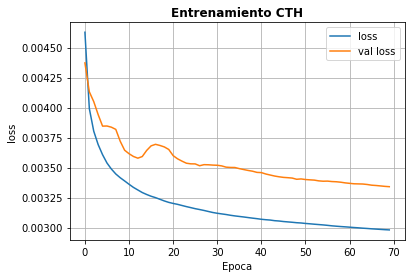

In [5]:
epochs = 70
learning_rate = 0.0015

modelo.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.MeanSquaredError(),
)

try:
    history = modelo.fit(
        secuenciador_train,
        epochs=epochs,
        validation_data=secuenciador_test,
        shuffle=False,
        verbose=1,
    )
except KeyboardInterrupt:
    print("Entrenamiento interumpido.")
    

plt.title("Entrenamiento CTH",weight="bold")
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val loss")
plt.xlabel("Epoca")
plt.ylabel("loss")
plt.grid()
plt.legend()

### Guardamos pesos

In [58]:
modelo.save_weights(f"{trainconfig.DIR_PESOS}/COD/pesos.tf",save_format="tf")
print(f"Pesos guardados en {trainconfig.DIR_PESOS}/COD/pesos.tf")

Pesos guardados en /home/felos/Repos/Deep-GOES/Modelos/Pesos//COD/pesos.tf


## Inspección visual resultados

Text(0.5, 1.0, 'y inferencia')

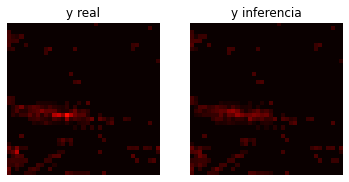

In [59]:
batch = 0
index = 49

x_prueba , y_real = secuenciador_test.__getitem__(batch)

y_real = y_real[index,:,:,0]
y_inferencia = modelo(x_prueba).numpy()
y_inferencia = y_inferencia[index]

fig,ax = plt.subplots(1,2)
for i in range(2): ax[i].axis("off")

ax[0].imshow(y_real,vmin=0,vmax=1,cmap="hot")
ax[0].set_title("y real")
im = ax[1].imshow(y_inferencia,vmin=0,vmax=1,cmap="hot")
ax[1].set_title("y inferencia")